# Projet : Classification d'aliments pour le tri automatique TP1

Kevin GUILBAUT, Aslam SABIR

## Imports des bibliothèques et de la base de données.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fruits' dataset.
Path to dataset files: /kaggle/input/fruits


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from functools import partial

import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

BASE_DIR = "/kaggle/input/fruits/fruits-360_100x100/fruits-360"

train_path = os.path.join(BASE_DIR, "Training")
test_path = os.path.join(BASE_DIR, "Test")

print(f"Dossier 'Training' : {os.path.exists(train_path)}")
print(f"Dossier 'Test' : {os.path.exists(test_path)}")


Dossier 'Training' : True
Dossier 'Test' : True


In [ ]:
BATCH_SIZE = 32
SEED = 23
NB_TOP_CLASSES=75

## Analyse Exploratoire

### Analyse de la distribution des classes

In [ ]:
# Lister les classes (qui sont les noms des sous-dossiers)
class_names = sorted(os.listdir(train_path))
print(f"Nombre total de classes : {len(class_names)}")
print("\nExemple de noms de classes :")
print(class_names[:10])

# Compter les images par classe
distribution = {}
for fruit_class in class_names:
    class_dir = os.path.join(train_path, fruit_class)
    # Compter le nombre de fichiers .jpg ou .png
    count = len([f for f in os.listdir(class_dir)
                 if f.endswith(('.jpg', '.png', '.jpeg'))])
    distribution[fruit_class] = count

# Convertir en DataFrame Pandas pour une analyse facile
df_distribution = pd.DataFrame(list(distribution.items()), columns=['Classe', 'Nombre d\'images'])

print(df_distribution.head())

print("\nStatistiques sur la distribution :")
print(df_distribution['Nombre d\'images'].describe())

Nombre total de classes : 226

Exemple de noms de classes :
['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']
     Classe  Nombre d'images
0  Apple 10              699
1  Apple 11              430
2  Apple 12              466
3  Apple 13              699
4  Apple 14              466

Statistiques sur la distribution :
count    226.000000
mean     525.588496
std      164.077146
min      144.000000
25%      454.500000
50%      490.000000
75%      694.000000
max      984.000000
Name: Nombre d'images, dtype: float64


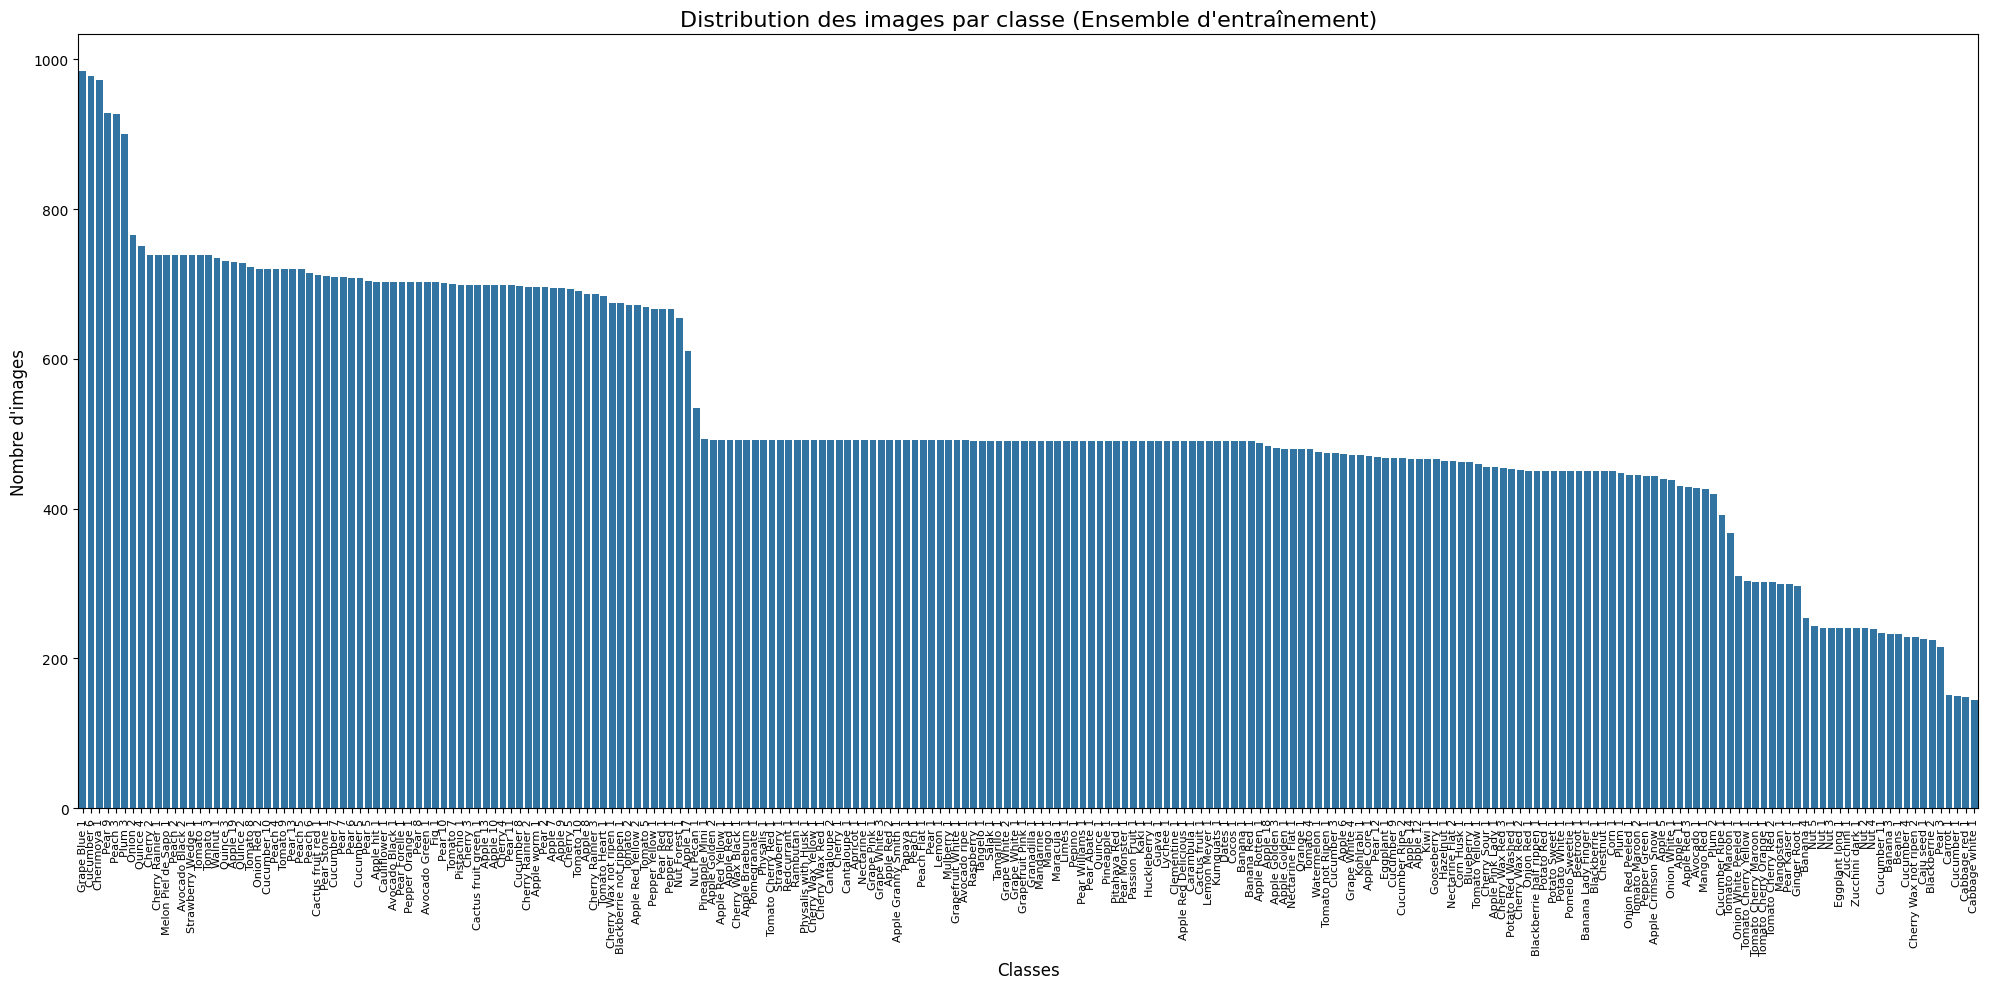

Classes avec le MOINS d'images :
              Classe  Nombre d'images
49   Cabbage white 1              144
48     Cabbage red 1              149
81        Cucumber 1              150
57          Carrot 1              151
158           Pear 3              215

Classes avec le PLUS d'images :
           Classe  Nombre d'images
100  Grape Blue 1              984
87     Cucumber 6              977
59    Cherimoya 1              972
163        Pear 9              928
147       Peach 3              927


In [ ]:
plt.figure(figsize=(20, 10))

# Trier par ordre decroissant
df_sorted = df_distribution.sort_values(by='Nombre d\'images', ascending=False)

sns.barplot(data=df_sorted, x='Classe', y='Nombre d\'images')

plt.title('Distribution des images par classe (Ensemble d\'entraînement)', fontsize=16)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.xlabel('Classes', fontsize=12)

plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

print("Classes avec le MOINS d'images :")
print(df_distribution.sort_values(by='Nombre d\'images', ascending=True).head())

print("\nClasses avec le PLUS d'images :")
print(df_distribution.sort_values(by='Nombre d\'images', ascending=False).head())

### Vérification dimension d'une image

In [ ]:
# Taille des images
sample_class = class_names[0]
sample_image_path = os.path.join(train_path, sample_class, os.listdir(os.path.join(train_path, sample_class))[10])
sample_image = Image.open(sample_image_path)
print(f"Taille d'une image exemple : {sample_image.size}")


Taille d'une image exemple : (100, 100)


### Visualisation d'échantillons aléatoires

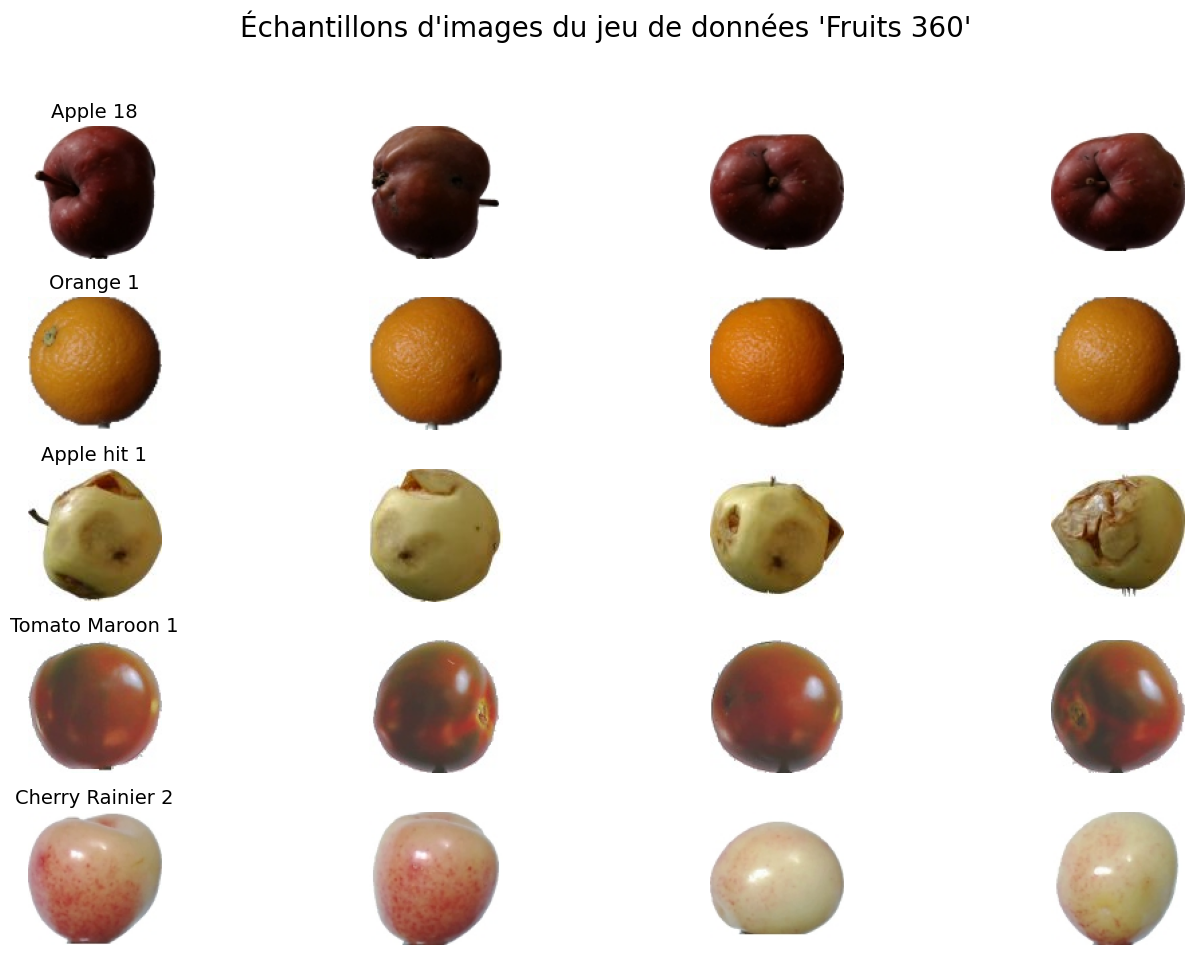

In [ ]:
num_classes_to_show = 5
num_images_per_class = 4

plt.figure(figsize=(15, 10))
# Prendre 5 classes au hasard
random_classes = np.random.choice(class_names, num_classes_to_show, replace=False)

for i, class_name in enumerate(random_classes):
    class_path = os.path.join(train_path, class_name)
    # Prendre 4 images au hasard
    all_image_files = os.listdir(class_path)

    if len(all_image_files) >= num_images_per_class:
        image_files = np.random.choice(all_image_files, num_images_per_class, replace=False)
    else:
        image_files = all_image_files
    for j, img_file in enumerate(image_files):
        img_path = os.path.join(class_path, img_file)

        # Lire l'image
        img = Image.open(img_path)

        ax = plt.subplot(num_classes_to_show, num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')

        # Titre pour la première image
        if j == 0:
            plt.title(class_name, fontsize=14)

plt.suptitle("Échantillons d'images du jeu de données 'Fruits 360'", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuster pour le titre
plt.show()

## Préparation et Prétraitement

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.squeeze(tf.cast(image, tf.float32), axis=-1) / 255.0, label


Compte tenu du grand nombre de classes et du volume de données, nous avons décidé de travailler uniquement sur les 75 classes les plus représentées.

In [ ]:

#  Garder les  classes principales
df_sorted = df_distribution.sort_values(by='Nombre d\'images', ascending=False)
TOP_CLASSES = df_sorted['Classe'].head(NB_TOP_CLASSES).tolist()

print(f"Les 5 classes gardées sont : {TOP_CLASSES}")
print(f"Nombre de classes total : {len(TOP_CLASSES)}")



train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(100,100),
    batch_size=BATCH_SIZE,
    class_names=TOP_CLASSES

)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(100,100),
    batch_size=BATCH_SIZE,
    class_names=TOP_CLASSES

)



test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(100, 100),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_names=TOP_CLASSES
)

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]

print(f"Valeur minimale : {np.min(first_image)}")
print(f"Valeur maximale : {np.max(first_image)}")

print(train_ds)

Les 5 classes gardées sont : ['Grape Blue 1', 'Cucumber 6', 'Cherimoya 1', 'Pear 9', 'Peach 3', 'Plum 3', 'Onion 2', 'Quince 4', 'Cherry 2', 'Cherry Rainier 1', 'Melon Piel de Sapo 1', 'Peach 2', 'Avocado Black 2', 'Strawberry Wedge 1', 'Tomato 1', 'Tomato 3', 'Walnut 1', 'Quince 3', 'Apple 19', 'Quince 2', 'Tomato 8', 'Onion Red 2', 'Cucumber 10', 'Peach 4', 'Tomato 9', 'Pear 13', 'Peach 5', 'Peach 6', 'Cactus fruit red 1', 'Pear Stone 1', 'Cucumber 7', 'Pear 7', 'Pear 6', 'Cucumber 5', 'Pear 5', 'Apple hit 1', 'Cauliflower 1', 'Avocado Black 1', 'Pear Forelle 1', 'Pepper Orange 1', 'Pear 8', 'Avocado Green 1', 'Fig 1', 'Pear 10', 'Tomato 7', 'Pistachio 1', 'Cherry 3', 'Cactus fruit green 1', 'Apple 13', 'Apple 10', 'Cherry 4', 'Pear 11', 'Cucumber 8', 'Cherry Rainier 2', 'Apple worm 1', 'Pear 2', 'Apple 7', 'Apple 9', 'Cherry 5', 'Tomato 10', 'Apple 8', 'Cherry Rainier 3', 'Tomato Heart 1', 'Cherry Wax not ripen 1', 'Blackberrie not rippen 1', 'Tomato 2', 'Apple Red Yellow 2', 'Tomat

## Baseline CNN

In [ ]:
IMAGE_SIZE = (100,100)
NUM_CLASSES = len(TOP_CLASSES)
NB_EPOCHS=15

input_shape = IMAGE_SIZE + (3,)
LEARNING_RATE = 0.001

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 307328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    19,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │         4,875 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,674,827 (75.05 MB)

 Trainable params: 19,674,827 (75.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_fit = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=NB_EPOCHS
)

Epoch 1/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 736s 545ms/step - accuracy: 0.0397 - loss: 4.7725 - val_accuracy: 0.4203 - val_loss: 2.1083
Epoch 2/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 682s 506ms/step - accuracy: 0.3538 - loss: 2.2254 - val_accuracy: 0.8457 - val_loss: 0.6412
Epoch 3/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 680s 504ms/step - accuracy: 0.5389 - loss: 1.4171 - val_accuracy: 0.9033 - val_loss: 0.3936
Epoch 4/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 693s 514ms/step - accuracy: 0.6095 - loss: 1.1917 - val_accuracy: 0.9266 - val_loss: 0.3281
Epoch 5/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 695s 515ms/step - accuracy: 0.6495 - loss: 1.0572 - val_accuracy: 0.9524 - val_loss: 0.2377
Epoch 6/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 740s 514ms/step - accuracy: 0.6829 - loss: 0.9600 - val_accuracy: 0.9609 - val_loss: 0.2206
Epoch 7/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 755s 524ms/step - accuracy: 0.6963 - loss: 0.9165 - val_accuracy: 0.9678 - val_loss: 0.1671
Epoch 8/15
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 719s 506ms/step - ac

In [ ]:

model.save('base_model.keras')

from google.colab import files

files.download('base_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Import de MobileNetV2

In [ ]:
# Entraînement Fine-Tuning
FINE_TUNE_EPOCHS = 5
TOTAL_EPOCHS = NB_EPOCHS + FINE_TUNE_EPOCHS

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet'
)

# Geler toutes les couches du modèle
base_model.trainable = False

# Construction de la tête de classification
inputs = tf.keras.Input(shape=(100, 100, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model_tl = tf.keras.Model(inputs, outputs)

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NB_EPOCHS-FINE_TUNE_EPOCHS,
    callbacks=[early_stop],
    verbose=1
)



# On dégèle tout d'abord le modèle
base_model.trainable = True

# On ne dégèle que les 30 dernières couches pour éviter de détruire les features pré-apprises
FINE_TUNE_AT = 30
for layer in base_model.layers[:-FINE_TUNE_AT]:
    layer.trainable = False

# Recompilation après modification du trainable
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_fine = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NB_EPOCHS,
    initial_epoch=history_tl.epoch[-1] + 1,
    callbacks=[early_stop],
    verbose=1
)

/tmp/ipython-input-2272679861.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 451s 331ms/step - accuracy: 0.7808 - loss: 0.8989 - val_accuracy: 0.9927 - val_loss: 0.0381
Epoch 2/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 434s 321ms/step - accuracy: 0.9863 - loss: 0.0530 - val_accuracy: 0.9948 - val_loss: 0.0219
Epoch 3/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 426s 316ms/step - accuracy: 0.9919 - loss: 0.0309 - val_accuracy: 0.9975 - val_loss: 0.0106
Epoch 4/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 484s 359ms/step - accuracy: 0.9930 - loss: 0.0232 - val_accuracy: 0.9968 - val_loss: 0.0100
Epoch 5/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 425s 315ms/step - accuracy: 0.9928 - loss: 0.0218 - val_accuracy: 0.9981 - val_loss: 0.0074
Epoch 6/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 426s 316ms/step - accuracy: 0.9950 - loss: 0.0161 - val_accuracy: 0.9986 - val_loss: 0.0055
Epoch 7/10
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 423s 314ms/step - accuracy: 0.9940 - loss: 0.0157 - val_accuracy: 0.9981 - val_loss: 0.0065
Epoch 8/10
13

In [ ]:

model_tl.save('model_tl.keras')

from google.colab import files

files.download('model_tl.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns


# Extraction des historiques
acc_custom = model_fit.history['accuracy']
val_acc_custom = model_fit.history['val_accuracy']
loss_custom = model_fit.history['loss']
val_loss_custom = model_fit.history['val_loss']



acc_ft = history_tl.history['accuracy'] + history_fine.history['accuracy']
val_acc_ft = history_tl.history['val_accuracy'] + history_fine.history['val_accuracy']
loss_ft = history_tl.history['loss'] + history_fine.history['loss']
val_loss_ft = history_tl.history['val_loss'] + history_fine.history['val_loss']

# Graphiques
epochs_range_custom = range(len(acc_custom))
epochs_range_ft = range(len(acc_ft))

plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range_custom, val_acc_custom, '--', label='Modele Custom', color='blue')
plt.plot(epochs_range_ft, val_acc_ft, '-', label='MobileNetV2 Fine-Tune', color='green', linewidth=2)
plt.title('Comparaison Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range_custom, val_loss_custom, '--', label='Modele Custom', color='blue')
plt.plot(epochs_range_ft, val_loss_ft, '-', label='MobileNetV2 Fine-Tune', color='green', linewidth=2)
plt.title('Comparaison Loss')
plt.legend(loc='upper right')

plt.show()





In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


#import keras

#path_base = '/content/drive/MyDrive/model_base.keras'
#path_tl = '/content/drive/MyDrive/model_tl.keras'

#model = keras.models.load_model(path_base)
#model_tl = keras.models.load_model(path_tl)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
class_names = TOP_CLASSES
y_true = np.concatenate([y for x, y in test_ds], axis=0)

predictions_prob_base = model.predict(test_ds)
y_pred_base = np.argmax(predictions_prob_base, axis=1)
predictions_prob = model_tl.predict(test_ds)
y_pred = np.argmax(predictions_prob, axis=1)

print(f"Accuracy base line: {accuracy_score(y_true, y_pred_base)}")
print(f"Accuracy MobileNetV2 Fine-Tune: {accuracy_score(y_true, y_pred)}")

print(classification_report(y_true, y_pred_base, target_names=class_names))



560/560 ━━━━━━━━━━━━━━━━━━━━ 67s 119ms/step
560/560 ━━━━━━━━━━━━━━━━━━━━ 149s 262ms/step
Accuracy base line: 0.9676590515556052
Accuracy MobileNetV2 Fine-Tune: 0.9881584092051612
                          precision    recall  f1-score   support

            Grape Blue 1       1.00      1.00      1.00       328
              Cucumber 6       0.95      1.00      0.97       325
             Cherimoya 1       1.00      1.00      1.00       320
                  Pear 9       1.00      1.00      1.00       308
                 Peach 3       1.00      1.00      1.00       306
                  Plum 3       1.00      1.00      1.00       304
                 Onion 2       0.88      0.99      0.93       255
                Quince 4       0.99      1.00      0.99       249
                Cherry 2       0.85      0.57      0.68       246
        Cherry Rainier 1       1.00      0.62      0.76       246
    Melon Piel de Sapo 1       1.00      0.89      0.94       246
                 Peach 2    

Nous observons une précision de 96,77 % pour le modèle baseline contre 98,82 % pour le MobileNetV2 Fine-Tuned. Cette amélioration était prévisible car le MobileNetV2 bénéficie du transfer learning : il réutilise des caractéristiques visuelles complexes déjà apprises sur la base massive ImageNet, ce qui lui permet de mieux généraliser que notre modèle simple entraîné de zéro.

On décide d'observer uniquement les 15 classes les plus mal prédites.

In [ ]:
cm = confusion_matrix(y_true, y_pred_base)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

np.fill_diagonal(df_cm.values, 0)

errors = df_cm.unstack().reset_index()
errors.columns = ['Predicted', 'True', 'Count']
errors = errors[errors['Count'] > 0]
errors = errors[['True', 'Predicted', 'Count']]

top_errors = errors.sort_values(by='Count', ascending=False).head(15)
print(top_errors.to_string(index=False))

                True            Predicted  Count
            Cherry 2             Cherry 4    107
    Cherry Rainier 1     Cherry Rainier 2     75
              Pear 2             Quince 3     48
        Pear Stone 1          Pistachio 1     36
     Pepper Orange 1      Pepper Yellow 1     28
          Pear Red 1     Cherry Rainier 3     25
       Cauliflower 1              Onion 2     24
        Pear Stone 1 Cactus fruit green 1     22
    Cherry Rainier 1             Cherry 2     19
            Tomato 3             Tomato 2     19
Melon Piel de Sapo 1         Pear Stone 1     15
              Pear 2               Pear 5     15
Melon Piel de Sapo 1              Onion 2     12
              Pear 2     Cherry Rainier 2     11
          Cucumber 7           Cucumber 6      9


En observant la matrice de confusion, nous remarquons que la majorité des erreurs se produisent entre des classes visuellement très proches. Le modèle confond fréquemment des variétés d'un même fruit (par exemple 'Cherry 2' prédit comme 'Cherry 4'). Cela indique que le modèle capte bien la forme globale du fruit, mais peine à distinguer les subtilités de texture ou de couleur spécifiques à chaque sous-variété.

Afin d'identifier les faiblesses des modèle, nous avons choisi d'isoler uniquement les 15 paires de classes générant le plus de confusions.

In [ ]:
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

np.fill_diagonal(df_cm.values, 0)

errors = df_cm.unstack().reset_index()
errors.columns = ['Predicted', 'True', 'Count']
errors = errors[errors['Count'] > 0]
errors = errors[['True', 'Predicted', 'Count']]

top_errors = errors.sort_values(by='Count', ascending=False).head(15)
print(top_errors.to_string(index=False))

                True                Predicted  Count
              Pear 2           Pear Forelle 1     59
      Tomato Heart 1             Pepper Red 1     58
            Tomato 1                 Tomato 3     30
        Nut Forest 1              Nut Pecan 1     27
    Cherry Rainier 1         Cherry Rainier 2     15
               Fig 1              Nut Pecan 1      8
            Cherry 4                 Cherry 2      4
            Tomato 1          Pepper Yellow 1      3
      Tomato Heart 1                 Tomato 1      2
              Pear 2                  Apple 9      2
              Pear 2                 Apple 13      1
Melon Piel de Sapo 1          Avocado Black 2      1
            Tomato 1                 Tomato 2      1
      Tomato Heart 1 Blackberrie not rippen 1      1


Bien que le MobileNetV2 améliore la précision globale, les erreurs résiduelles restent concentrées sur ces confusions "inter-variétés". Par exemple, la distinction entre 'Tomato 1' etT'Tomato 3'. On observe qu'il se trompe sur différentes classe que notre model base.

In [ ]:
!pip install optuna

In [ ]:
import optuna

ModuleNotFoundError: No module named 'optuna'

In [ ]:
raw_train = tf.keras.utils.image_dataset_from_directory(
    train_path, validation_split=0.2, subset="training", seed=SEED,
    image_size=IMAGE_SIZE, batch_size=None, class_names=TOP_CLASSES, verbose=0
)
raw_val = tf.keras.utils.image_dataset_from_directory(
    train_path, validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMAGE_SIZE, batch_size=None, class_names=TOP_CLASSES, verbose=0
)

# Normalisation
norm_layer = tf.keras.layers.Rescaling(1./255)
train_norm = raw_train.map(lambda x, y: (norm_layer(x), y))
val_norm = raw_val.map(lambda x, y: (norm_layer(x), y))

def objective(trial):
    tf.keras.backend.clear_session() # Vital pour libérer la RAM entre les essais

    lr = trial.suggest_float('learning_rate', 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    # Application du batch size dynamique
    train_ds = train_norm.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_norm.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape), # Correction du warning
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(train_ds, validation_data=val_ds, epochs=5, verbose=0)
    return history.history['val_accuracy'][-1]

print("Démarrage de l'optimisation Optuna")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, show_progress_bar=True)

print(f"Meilleurs paramètres : {study.best_params}")
print(f"Meilleure Accuracy : {study.best_value:.2%}")

LEARNING_RATE = study.best_params['learning_rate']
BATCH_SIZE = study.best_params['batch_size']

Using 43138 files for training.
Using 10784 files for validation.


[I 2025-11-23 14:54:00,821] A new study created in memory with name: no-name-06cc3489-8710-427c-885e-28a2c8a1b56f


Démarrage de l'optimisation Optuna


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-11-23 15:38:44,844] Trial 0 finished with value: 0.9454748034477234 and parameters: {'learning_rate': 0.009245239639068557, 'batch_size': 64}. Best is trial 0 with value: 0.9454748034477234.
[I 2025-11-23 16:22:45,364] Trial 1 finished with value: 0.9691209197044373 and parameters: {'learning_rate': 0.006683173906054177, 'batch_size': 64}. Best is trial 1 with value: 0.9691209197044373.
[I 2025-11-23 17:23:45,785] Trial 2 finished with value: 0.016969583928585052 and parameters: {'learning_rate': 0.009281731458661685, 'batch_size': 32}. Best is trial 1 with value: 0.9691209197044373.
[I 2025-11-23 18:27:46,090] Trial 3 finished with value: 0.9024480581283569 and parameters: {'learning_rate': 0.008189308289566752, 'batch_size': 32}. Best is trial 1 with value: 0.9691209197044373.
[I 2025-11-23 19:13:48,303] Trial 4 finished with value: 0.8252040147781372 and parameters: {'learning_rate': 0.0022298839617300773, 'batch_size': 64}. Best is trial 1 with value: 0.9691209197044373.
[I

Pour affiner notre modèle personnalisé, nous avons privilégié l'utilisation du framework Optuna plutôt qu'une méthode classique de type "Grid Search" ou une simple boucle de validation croisée. Contrairement à ces méthodes qui explorent l'espace de recherche de manière exhaustive ou aléatoire, Optuna utilise une approche bayésienne. Cela lui permet d'apprendre des essais précédents pour cibler intelligemment les combinaisons d'hyperparamètres (Learning Rate, Batch Size) les plus prometteuses, offrant ainsi un gain de temps et de performance théorique significatif.

Malheureusement, un problème de connexion a interrompu l'exécution de l'étude  alors que celle-ci était complétée à environ 80%. En raison des contraintes de temps, nous n'avons pas pu relancer l'intégralité du processus d'optimisation pour isoler et entraîner le modèle définitif. L'objectif initial de cette démarche était de générer ce "Meilleur Modèle Custom" pour le confronter au jeu de données de test et comparer ses performances face au MobileNetV2. Cette comparaison nous aurait permis de vérifier si un réseau CNN simple mais optimisé pouvait rivaliser avec la puissance d'un modèle de Transfer Learning pré-entraîné sur ImageNet.